# Hotel Deals & Value Analysis - Deep Dive EDA

This notebook performs comprehensive exploratory data analysis to:
1. Understand date ranges and temporal patterns in our scraped data
2. Define what constitutes 'deals' and 'value'
3. Surface the best deals for users
4. Provide actionable recommendations

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Database path
DB_PATH = Path('../data/storage/hotels.sqlite3')

# Connect to database
conn = sqlite3.connect(DB_PATH)
print(f"✓ Connected to database: {DB_PATH}")
print(f"Database size: {DB_PATH.stat().st_size / (1024**3):.2f} GB")

✓ Connected to database: ../data/storage/hotels.sqlite3
Database size: 20.03 GB


## 1. Database Overview & Data Volume

In [6]:
# Get table sizes - simplified query
query = """
SELECT 
    name as table_name,
    type
FROM sqlite_master
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
"""

tables_info = pd.read_sql_query(query, conn)
print("\nDatabase Tables:")
print("="*80)

# Get row counts for each table
table_stats = []
for table in tables_info['table_name']:
    count_query = f"SELECT COUNT(*) as count FROM {table}"
    count = pd.read_sql_query(count_query, conn)['count'][0]
    table_stats.append({'Table': table, 'Row Count': f"{count:,}"})

stats_df = pd.DataFrame(table_stats)
print(stats_df.to_string(index=False))


Database Tables:
                 Table Row Count
          destinations       173
        hotel_features   313,480
hotel_program_benefits    15,236
      hotel_promotions     1,123
                hotels     2,820
                  meta         1
       rate_components 3,786,984
   rate_nightly_prices 2,147,637
        rate_snapshots   722,705
            room_types    18,164
       search_payloads    21,662
           search_runs    21,738


## 2. Date Range Analysis

In [7]:
# Analyze search runs and date coverage
date_query = """
SELECT 
    MIN(check_in) as earliest_check_in,
    MAX(check_in) as latest_check_in,
    MIN(check_out) as earliest_check_out,
    MAX(check_out) as latest_check_out,
    COUNT(DISTINCT check_in) as unique_check_in_dates,
    COUNT(DISTINCT destination_key) as unique_destinations,
    COUNT(*) as total_search_runs,
    SUM(CASE WHEN status='complete' THEN 1 ELSE 0 END) as completed_runs,
    AVG(nights) as avg_nights,
    AVG(adults) as avg_adults,
    AVG(total_hotels) as avg_hotels_per_run,
    AVG(total_rates) as avg_rates_per_run
FROM search_runs;
"""

date_summary = pd.read_sql_query(date_query, conn)
print("\nDate Range Coverage:")
print("="*80)
for col in date_summary.columns:
    print(f"{col:30s}: {date_summary[col].iloc[0]}")


Date Range Coverage:
earliest_check_in             : 2025-01-05
latest_check_in               : 2026-10-07
earliest_check_out            : 2025-01-08
latest_check_out              : 2026-10-10
unique_check_in_dates         : 358
unique_destinations           : 173
total_search_runs             : 21738
completed_runs                : 21660
avg_nights                    : 2.9971018492961634
avg_adults                    : 2.0
avg_hotels_per_run            : 19.65548808538044
avg_rates_per_run             : 60.626874597479066


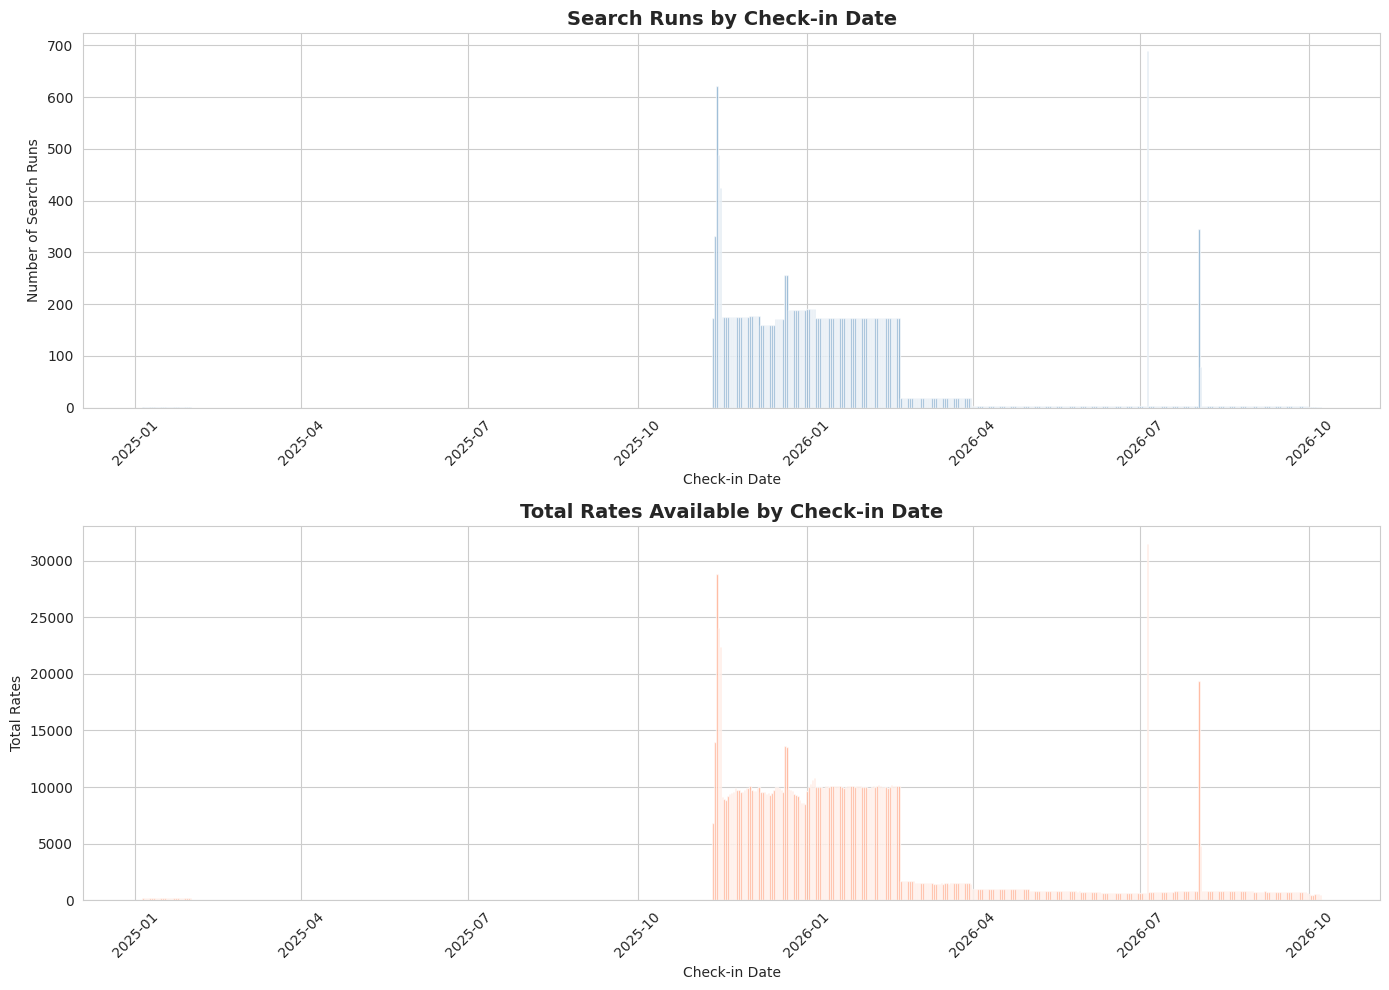


Total check-in dates covered: 358
Date range: 2025-01-05 00:00:00 to 2026-10-07 00:00:00


In [8]:
# Temporal distribution of search runs
temporal_query = """
SELECT 
    check_in,
    COUNT(*) as run_count,
    COUNT(DISTINCT destination_key) as destination_count,
    SUM(total_rates) as total_rates
FROM search_runs
WHERE status = 'complete'
GROUP BY check_in
ORDER BY check_in;
"""

temporal_df = pd.read_sql_query(temporal_query, conn)
temporal_df['check_in'] = pd.to_datetime(temporal_df['check_in'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot search runs over time
axes[0].bar(temporal_df['check_in'], temporal_df['run_count'], alpha=0.7, color='steelblue')
axes[0].set_title('Search Runs by Check-in Date', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Check-in Date')
axes[0].set_ylabel('Number of Search Runs')
axes[0].tick_params(axis='x', rotation=45)

# Plot total rates over time
axes[1].bar(temporal_df['check_in'], temporal_df['total_rates'], alpha=0.7, color='coral')
axes[1].set_title('Total Rates Available by Check-in Date', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Check-in Date')
axes[1].set_ylabel('Total Rates')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nTotal check-in dates covered: {len(temporal_df)}")
print(f"Date range: {temporal_df['check_in'].min()} to {temporal_df['check_in'].max()}")

## 3. Rate Snapshot Analysis - Understanding Pricing

In [9]:
# Load sample of rate data with hotel information
rates_query = """
SELECT 
    rs.id as snapshot_id,
    rs.run_id,
    sr.check_in,
    sr.check_out,
    sr.nights,
    sr.adults,
    sr.destination_name,
    sr.destination_group,
    h.property_id,
    h.name as hotel_name,
    h.star_rating,
    h.user_rating,
    h.user_rating_count,
    h.brand_name,
    h.chain_name,
    h.address_city,
    h.address_country_name,
    rt.name as room_type_name,
    rs.pricing_currency,
    rs.pricing_total,
    rs.pricing_total_inclusive,
    rs.pricing_base,
    rs.average_nightly_rate,
    rs.pricing_total_fees,
    rs.pricing_total_taxes,
    rs.is_breakfast_included,
    rs.is_food_beverage_credit,
    rs.is_free_cancellation,
    rs.is_parking_included,
    rs.is_shuttle_included,
    rs.payment_model,
    rs.points_burn,
    rs.hotel_collection,
    rs.special_offer_json,
    rs.available
FROM rate_snapshots rs
JOIN search_runs sr ON rs.run_id = sr.id
JOIN hotels h ON rs.property_id = h.property_id
LEFT JOIN room_types rt ON rs.property_id = rt.property_id AND rs.room_type_id = rt.room_type_id
WHERE sr.status = 'complete'
    AND rs.pricing_total IS NOT NULL
    AND rs.pricing_total > 0
LIMIT 100000;
"""

print("Loading rate data (this may take a moment for large datasets)...")
rates_df = pd.read_sql_query(rates_query, conn)
print(f"✓ Loaded {len(rates_df):,} rate snapshots")

# Convert dates
rates_df['check_in'] = pd.to_datetime(rates_df['check_in'])
rates_df['check_out'] = pd.to_datetime(rates_df['check_out'])

# Display sample
print("\nSample of rate data:")
display(rates_df.head(10))

Loading rate data (this may take a moment for large datasets)...
✓ Loaded 100,000 rate snapshots

Sample of rate data:


,snapshot_id,run_id,check_in,check_out,nights,adults,destination_name,destination_group,property_id,hotel_name,...,is_breakfast_included,is_food_beverage_credit,is_free_cancellation,is_parking_included,is_shuttle_included,payment_model,points_burn,hotel_collection,special_offer_json,available
0,1,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-1631412,The Peninsula Tokyo,...,0,0,0,0,0,PAY_NOW,224187.0,FHR,None,3
1,2,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-1631412,The Peninsula Tokyo,...,0,0,0,0,0,PAY_NOW,232044.0,FHR,None,51
2,3,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-7473589,Andaz Tokyo Toranomon Hills - a concept by Hyatt,...,0,0,0,0,0,PAY_NOW,137540.0,FHR,None,27
3,4,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-7473589,Andaz Tokyo Toranomon Hills - a concept by Hyatt,...,0,0,0,0,0,PAY_NOW,140268.0,FHR,None,38
4,5,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-2167,Grand Hyatt Tokyo,...,0,0,1,0,0,PAY_NOW,130179.0,FHR,None,60
5,6,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-2167,Grand Hyatt Tokyo,...,0,0,1,0,0,PAY_NOW,134315.0,FHR,None,9
6,7,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-82927328,Fuji Speedway Hotel - The Unbound Collection b...,...,0,0,1,1,0,PAY_NOW,66165.0,FHR,None,6
7,8,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-82927328,Fuji Speedway Hotel - The Unbound Collection b...,...,0,0,1,1,0,PAY_NOW,66165.0,FHR,None,11
8,9,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-17310194,Conrad Osaka,...,0,0,1,0,0,PAY_NOW,103003.0,FHR,None,9
9,10,2,2026-01-01,2026-01-02,1,2,Japan,Asia Pacific,ZHOT-EXPEDIA-17310194,Conrad Osaka,...,0,0,1,0,0,PAY_NOW,103003.0,FHR,None,9


In [10]:
# Basic pricing statistics
print("\nPricing Overview:")
print("="*80)
print(f"Currency distribution:")
print(rates_df['pricing_currency'].value_counts())
print(f"\nPrice Statistics (Total):")
print(rates_df['pricing_total'].describe())
print(f"\nAverage Nightly Rate Statistics:")
print(rates_df['average_nightly_rate'].describe())


Pricing Overview:
Currency distribution:
pricing_currency
USD    99931
AED       34
CAD       32
THB        3
Name: count, dtype: int64

Price Statistics (Total):
count    1.000000e+05
mean     2.735889e+03
std      1.534603e+04
min      1.106600e+02
25%      1.034727e+03
50%      1.743490e+03
75%      3.037240e+03
max      2.999997e+06
Name: pricing_total, dtype: float64

Average Nightly Rate Statistics:
count    100000.000000
mean        830.514953
std        4723.466958
min          32.530000
25%         353.932500
50%         561.165000
75%         931.992500
max      842459.140000
Name: average_nightly_rate, dtype: float64


## 4. Defining 'Value' & 'Deals'

We'll define value metrics based on multiple dimensions:
1. **Price per Night** - Lower is better
2. **Star Rating per Dollar** - Higher star rating for lower price
3. **Amenity Score** - More included amenities = better value
4. **User Rating Quality** - High rated hotels at low prices
5. **Special Offers** - Properties with promotions
6. **Collection Status** - Premium collections (FHR, THC, etc.)

In [11]:
# Calculate amenity score (each amenity adds points)
rates_df['amenity_score'] = (
    rates_df['is_breakfast_included'].fillna(0) * 2 +  # Breakfast is valuable
    rates_df['is_food_beverage_credit'].fillna(0) * 2 +  # F&B credit is valuable
    rates_df['is_free_cancellation'].fillna(0) * 1 +
    rates_df['is_parking_included'].fillna(0) * 1 +
    rates_df['is_shuttle_included'].fillna(0) * 0.5
)

# Calculate value metrics
rates_df['price_per_night'] = rates_df['pricing_total'] / rates_df['nights']
rates_df['has_special_offer'] = rates_df['special_offer_json'].notna().astype(int)
rates_df['is_premium_collection'] = rates_df['hotel_collection'].notna().astype(int)

# Star rating value (stars per $100)
rates_df['star_value'] = (rates_df['star_rating'].fillna(0) / (rates_df['price_per_night'] / 100)).replace([np.inf, -np.inf], np.nan)

# User rating value (rating per $100)
rates_df['rating_value'] = (rates_df['user_rating'].fillna(0) / (rates_df['price_per_night'] / 100)).replace([np.inf, -np.inf], np.nan)

# Composite value score (normalized 0-100)
# Higher score = better value
rates_df['value_score'] = (
    rates_df['amenity_score'] * 10 +  # Amenities (0-65 points)
    rates_df['star_value'].fillna(0) * 5 +  # Star value (variable)
    rates_df['rating_value'].fillna(0) * 5 +  # Rating value (variable)
    rates_df['has_special_offer'] * 10 +  # Special offer bonus
    rates_df['is_premium_collection'] * 5  # Premium collection bonus
)

print("✓ Calculated value metrics")
print(f"\nValue Score Distribution:")
print(rates_df['value_score'].describe())

✓ Calculated value metrics

Value Score Distribution:
count    100000.000000
mean         30.074049
std          11.255174
min           5.128133
25%          21.185057
50%          28.769781
75%          36.940668
max         128.018254
Name: value_score, dtype: float64


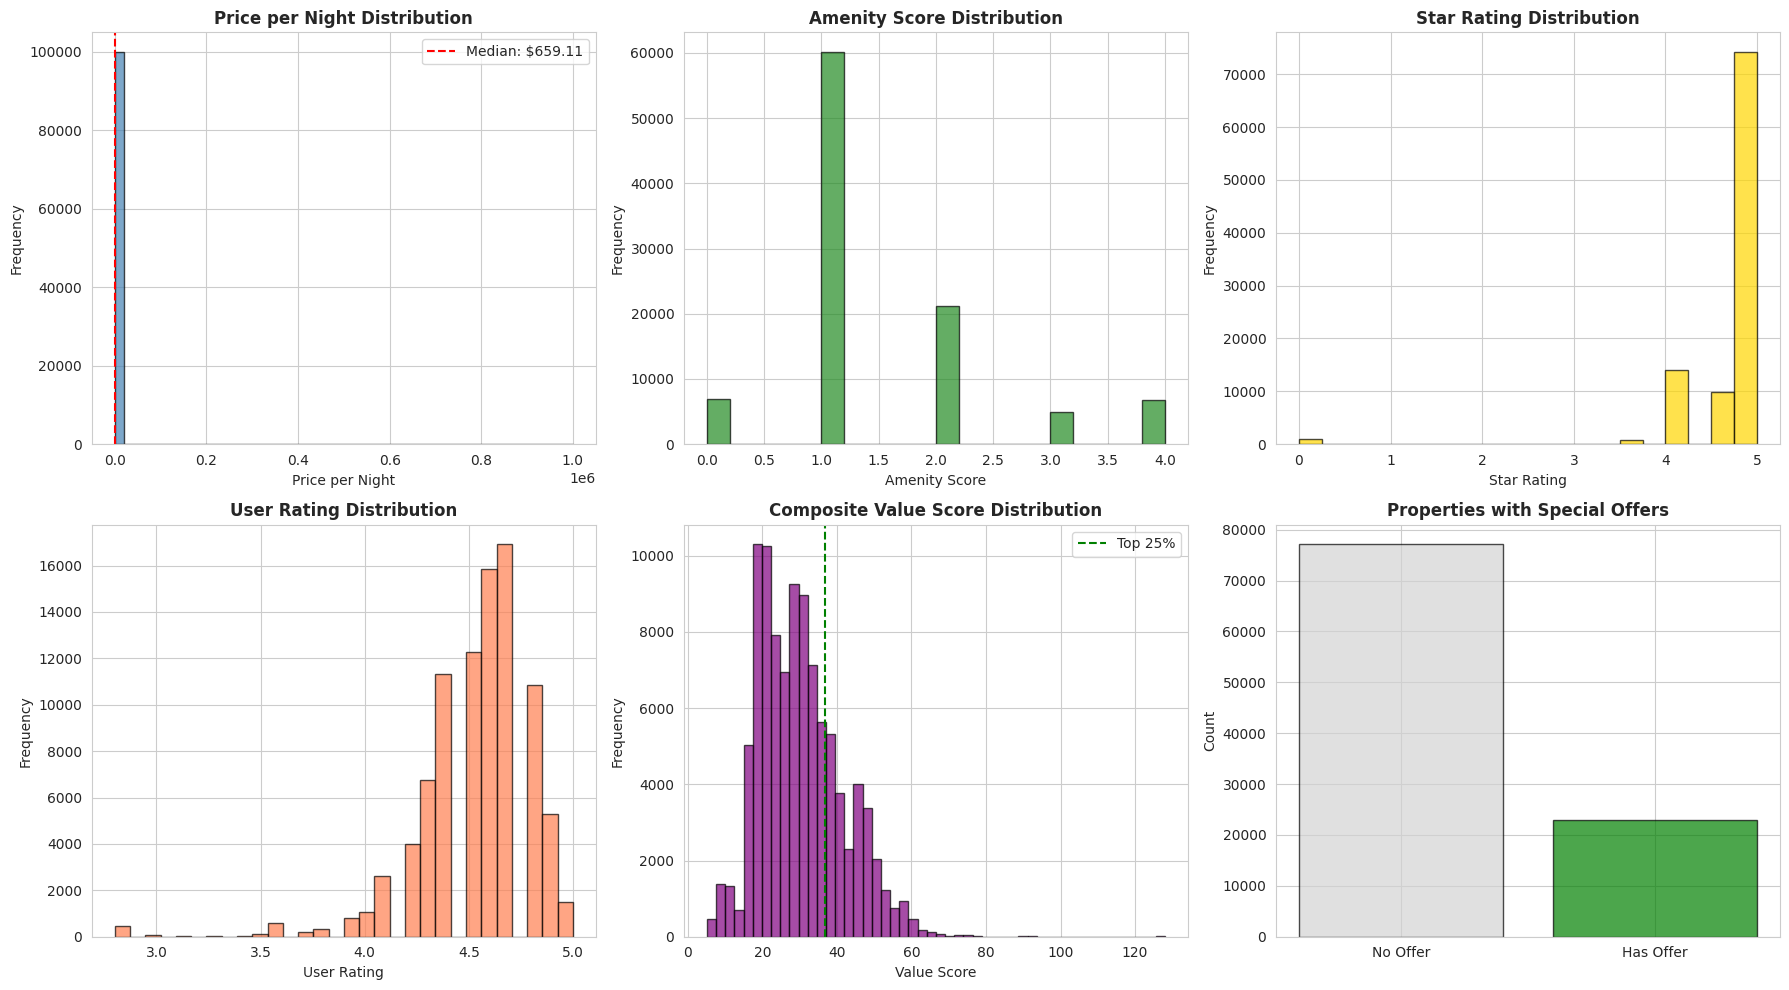

In [12]:
# Visualize value components
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Price per night distribution
axes[0, 0].hist(rates_df['price_per_night'].dropna(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Price per Night Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Price per Night')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(rates_df['price_per_night'].median(), color='red', linestyle='--', label=f'Median: ${rates_df["price_per_night"].median():.2f}')
axes[0, 0].legend()

# Amenity score distribution
axes[0, 1].hist(rates_df['amenity_score'], bins=20, color='forestgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Amenity Score Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Amenity Score')
axes[0, 1].set_ylabel('Frequency')

# Star rating distribution
axes[0, 2].hist(rates_df['star_rating'].dropna(), bins=20, color='gold', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Star Rating Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Star Rating')
axes[0, 2].set_ylabel('Frequency')

# User rating distribution
axes[1, 0].hist(rates_df['user_rating'].dropna(), bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('User Rating Distribution', fontweight='bold')
axes[1, 0].set_xlabel('User Rating')
axes[1, 0].set_ylabel('Frequency')

# Value score distribution
axes[1, 1].hist(rates_df['value_score'].dropna(), bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Composite Value Score Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Value Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(rates_df['value_score'].quantile(0.75), color='green', linestyle='--', label='Top 25%')
axes[1, 1].legend()

# Special offers vs regular
offer_counts = rates_df['has_special_offer'].value_counts()
axes[1, 2].bar(['No Offer', 'Has Offer'], offer_counts.values, color=['lightgray', 'green'], alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Properties with Special Offers', fontweight='bold')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 5. Best Deals Analysis

In [13]:
# Define "best deals" as top quartile value scores
value_threshold = rates_df['value_score'].quantile(0.75)
best_deals = rates_df[rates_df['value_score'] >= value_threshold].copy()

print(f"\nBest Deals Criteria:")
print(f"  Value Score >= {value_threshold:.2f} (top 25%)")
print(f"\nTotal Best Deals Found: {len(best_deals):,}")
print(f"Percentage of all rates: {len(best_deals)/len(rates_df)*100:.1f}%")

# Analyze best deals
print(f"\nBest Deals Summary:")
print("="*80)
print(f"Average price per night: ${best_deals['price_per_night'].mean():.2f}")
print(f"Median price per night: ${best_deals['price_per_night'].median():.2f}")
print(f"Average star rating: {best_deals['star_rating'].mean():.2f}")
print(f"Average user rating: {best_deals['user_rating'].mean():.2f}")
print(f"Average amenity score: {best_deals['amenity_score'].mean():.2f}")
print(f"Percentage with special offers: {best_deals['has_special_offer'].mean()*100:.1f}%")
print(f"Percentage in premium collections: {best_deals['is_premium_collection'].mean()*100:.1f}%")


Best Deals Criteria:
  Value Score >= 36.94 (top 25%)

Total Best Deals Found: 25,001
Percentage of all rates: 25.0%

Best Deals Summary:
Average price per night: $963.85
Median price per night: $488.50
Average star rating: 4.76
Average user rating: 4.60
Average amenity score: 2.49
Percentage with special offers: 44.1%
Percentage in premium collections: 100.0%


In [14]:
# Top 20 best value hotels across all dates
top_deals = (
    best_deals
    .groupby(['property_id', 'hotel_name', 'destination_name'])
    .agg({
        'value_score': 'mean',
        'price_per_night': 'mean',
        'star_rating': 'first',
        'user_rating': 'first',
        'amenity_score': 'mean',
        'has_special_offer': 'max',
        'snapshot_id': 'count'
    })
    .rename(columns={'snapshot_id': 'availability_count'})
    .sort_values('value_score', ascending=False)
    .head(20)
    .reset_index()
)

# Format for display
top_deals['price_per_night'] = top_deals['price_per_night'].apply(lambda x: f"${x:.2f}")
top_deals['value_score'] = top_deals['value_score'].apply(lambda x: f"{x:.1f}")
top_deals['star_rating'] = top_deals['star_rating'].apply(lambda x: f"{x:.1f}★" if pd.notna(x) else 'N/A')
top_deals['user_rating'] = top_deals['user_rating'].apply(lambda x: f"{x:.1f}" if pd.notna(x) else 'N/A')

print("\n🏆 TOP 20 BEST VALUE HOTELS:")
print("="*120)
display(top_deals[['hotel_name', 'destination_name', 'value_score', 'price_per_night', 
                    'star_rating', 'user_rating', 'amenity_score', 'availability_count']])


🏆 TOP 20 BEST VALUE HOTELS:


,hotel_name,destination_name,value_score,price_per_night,star_rating,user_rating,amenity_score,availability_count
0,MGM Grand Hotel & Casino,Nevada,87.6,$91.32,4.0★,3.6,1.00000,23
1,"Virgin Hotels Las Vegas, Curio Collection by H...",Nevada,72.7,$92.76,4.5★,3.6,2.00000,32
2,NH Collection Quito Royal,Ecuador,67.5,$118.50,5.0★,4.4,2.00000,28
3,Viceroy At Ombria Algarve,Portugal,66.8,$340.05,5.0★,4.6,3.87500,32
4,Park MGM Las Vegas,Nevada,64.8,$104.42,4.0★,3.9,1.00000,30
5,Kimpton Gray Hotel by IHG,Illinois,63.9,$117.78,4.5★,4.6,1.00000,20
6,Canopy by Hilton Dubai Al Seef,United Arab Emirates,63.6,$177.45,4.0★,4.6,2.00000,28
7,Our Habitas Bacalar – Adults Only,Quintana Roo,63.2,$431.40,5.0★,4.6,3.71875,32
8,Hotel Lilla Roberts,Finland,62.8,$168.07,4.5★,4.6,2.92000,25
9,La Zambra Resort Mijas - Marbella The Unbound ...,Spain,62.2,$449.52,5.0★,4.8,4.00000,32


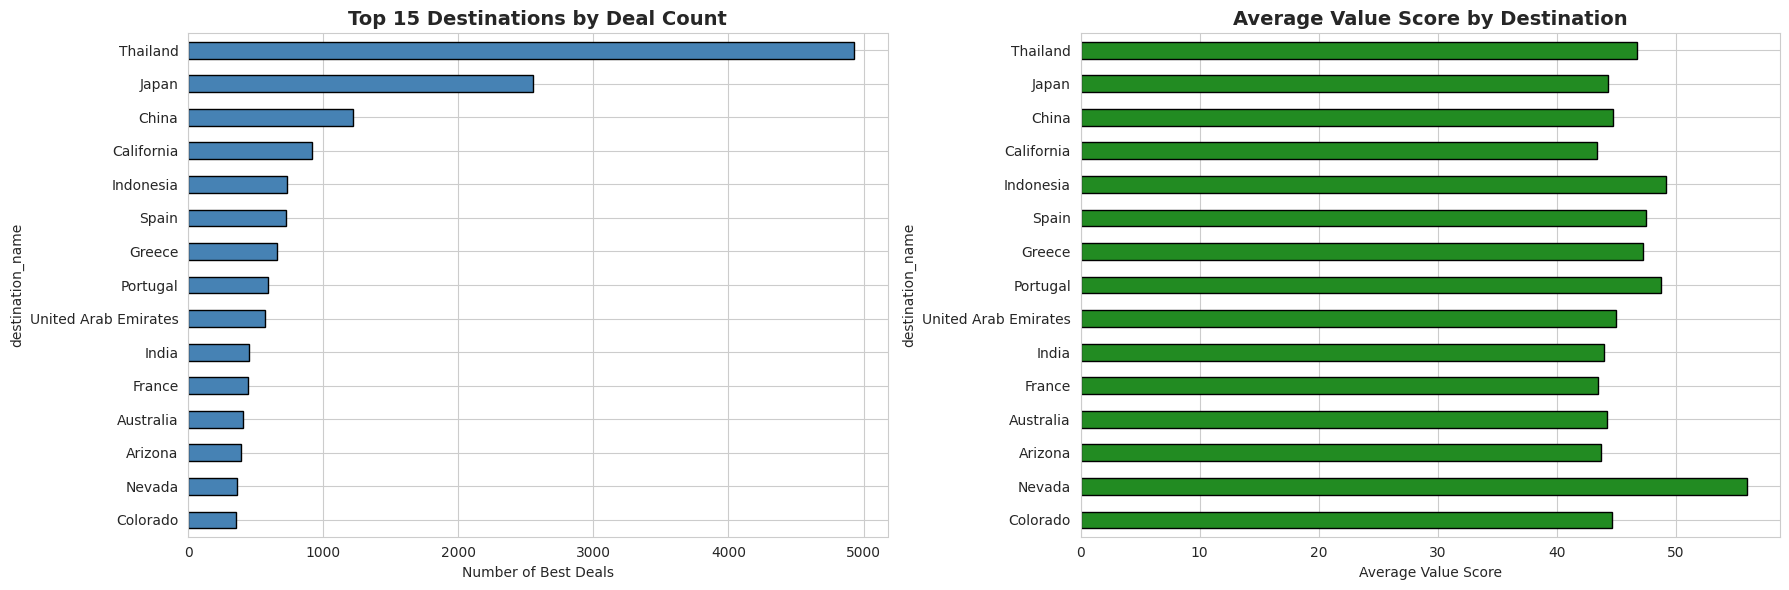

In [15]:
# Best deals by destination
deals_by_dest = (
    best_deals
    .groupby('destination_name')
    .agg({
        'snapshot_id': 'count',
        'value_score': 'mean',
        'price_per_night': 'mean'
    })
    .rename(columns={'snapshot_id': 'deal_count'})
    .sort_values('deal_count', ascending=False)
    .head(15)
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot deal count by destination
deals_by_dest['deal_count'].plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Top 15 Destinations by Deal Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Best Deals')
axes[0].invert_yaxis()

# Plot average value score by destination
deals_by_dest['value_score'].plot(kind='barh', ax=axes[1], color='forestgreen', edgecolor='black')
axes[1].set_title('Average Value Score by Destination', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Value Score')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Temporal Patterns - When Are the Best Deals?

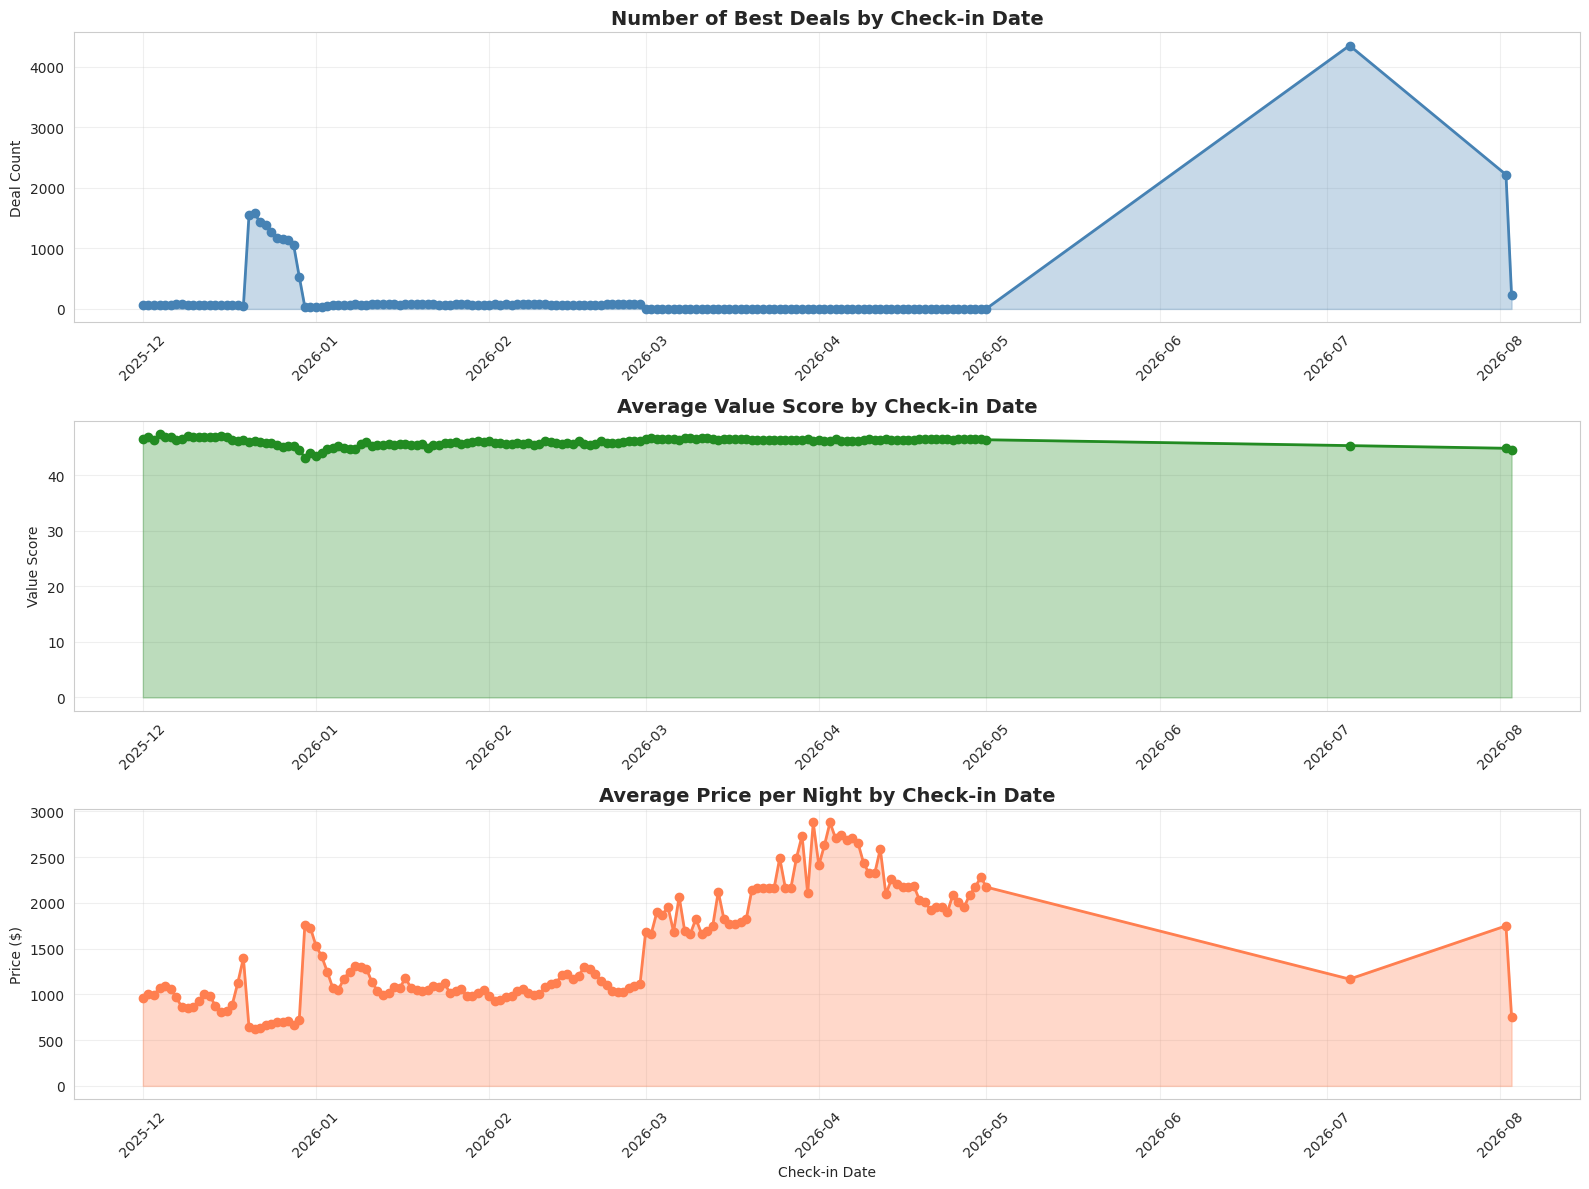


📅 BEST CHECK-IN DATES:
2026-07-05: 4355 deals, avg value score: 45.4, avg price: $1167.43
2026-08-02: 2220 deals, avg value score: 44.9, avg price: $1749.22
2025-12-21: 1579 deals, avg value score: 46.2, avg price: $622.23
2025-12-20: 1549 deals, avg value score: 46.1, avg price: $639.31
2025-12-22: 1434 deals, avg value score: 46.1, avg price: $633.97


In [16]:
# Analyze deals by check-in date
deals_over_time = (
    best_deals
    .groupby(best_deals['check_in'].dt.date)
    .agg({
        'snapshot_id': 'count',
        'value_score': 'mean',
        'price_per_night': 'mean'
    })
    .rename(columns={'snapshot_id': 'deal_count'})
)

deals_over_time.index = pd.to_datetime(deals_over_time.index)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Deal count over time
axes[0].plot(deals_over_time.index, deals_over_time['deal_count'], marker='o', color='steelblue', linewidth=2)
axes[0].fill_between(deals_over_time.index, deals_over_time['deal_count'], alpha=0.3, color='steelblue')
axes[0].set_title('Number of Best Deals by Check-in Date', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Deal Count')
axes[0].grid(True, alpha=0.3)

# Average value score over time
axes[1].plot(deals_over_time.index, deals_over_time['value_score'], marker='o', color='forestgreen', linewidth=2)
axes[1].fill_between(deals_over_time.index, deals_over_time['value_score'], alpha=0.3, color='forestgreen')
axes[1].set_title('Average Value Score by Check-in Date', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Value Score')
axes[1].grid(True, alpha=0.3)

# Average price over time
axes[2].plot(deals_over_time.index, deals_over_time['price_per_night'], marker='o', color='coral', linewidth=2)
axes[2].fill_between(deals_over_time.index, deals_over_time['price_per_night'], alpha=0.3, color='coral')
axes[2].set_title('Average Price per Night by Check-in Date', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Price ($)')
axes[2].set_xlabel('Check-in Date')
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Find best dates
print("\n📅 BEST CHECK-IN DATES:")
print("="*80)
best_dates = deals_over_time.nlargest(5, 'deal_count')
for date, row in best_dates.iterrows():
    print(f"{date.strftime('%Y-%m-%d')}: {row['deal_count']:.0f} deals, avg value score: {row['value_score']:.1f}, avg price: ${row['price_per_night']:.2f}")

## 7. Amenity Analysis - What Drives Value?

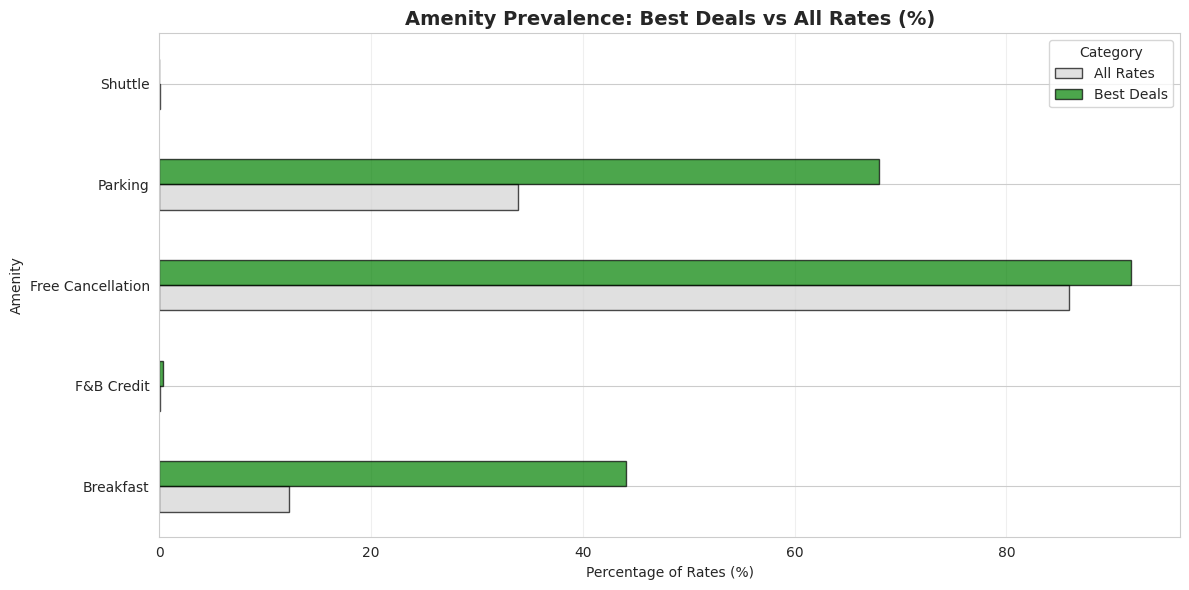


🎁 AMENITY ANALYSIS:
                   All Rates  Best Deals
Breakfast               12.3        44.0
F&B Credit               0.1         0.3
Free Cancellation       85.9        91.8
Parking                 33.8        68.0
Shuttle                  0.0         0.0


In [17]:
# Compare amenities in best deals vs all rates
amenity_comparison = pd.DataFrame({
    'All Rates': [
        rates_df['is_breakfast_included'].mean() * 100,
        rates_df['is_food_beverage_credit'].mean() * 100,
        rates_df['is_free_cancellation'].mean() * 100,
        rates_df['is_parking_included'].mean() * 100,
        rates_df['is_shuttle_included'].mean() * 100,
    ],
    'Best Deals': [
        best_deals['is_breakfast_included'].mean() * 100,
        best_deals['is_food_beverage_credit'].mean() * 100,
        best_deals['is_free_cancellation'].mean() * 100,
        best_deals['is_parking_included'].mean() * 100,
        best_deals['is_shuttle_included'].mean() * 100,
    ]
}, index=['Breakfast', 'F&B Credit', 'Free Cancellation', 'Parking', 'Shuttle'])

# Plot comparison
amenity_comparison.plot(kind='barh', figsize=(12, 6), color=['lightgray', 'green'], alpha=0.7, edgecolor='black')
plt.title('Amenity Prevalence: Best Deals vs All Rates (%)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Rates (%)')
plt.ylabel('Amenity')
plt.legend(title='Category')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n🎁 AMENITY ANALYSIS:")
print("="*80)
print(amenity_comparison.round(1))

## 8. Price vs Quality Analysis

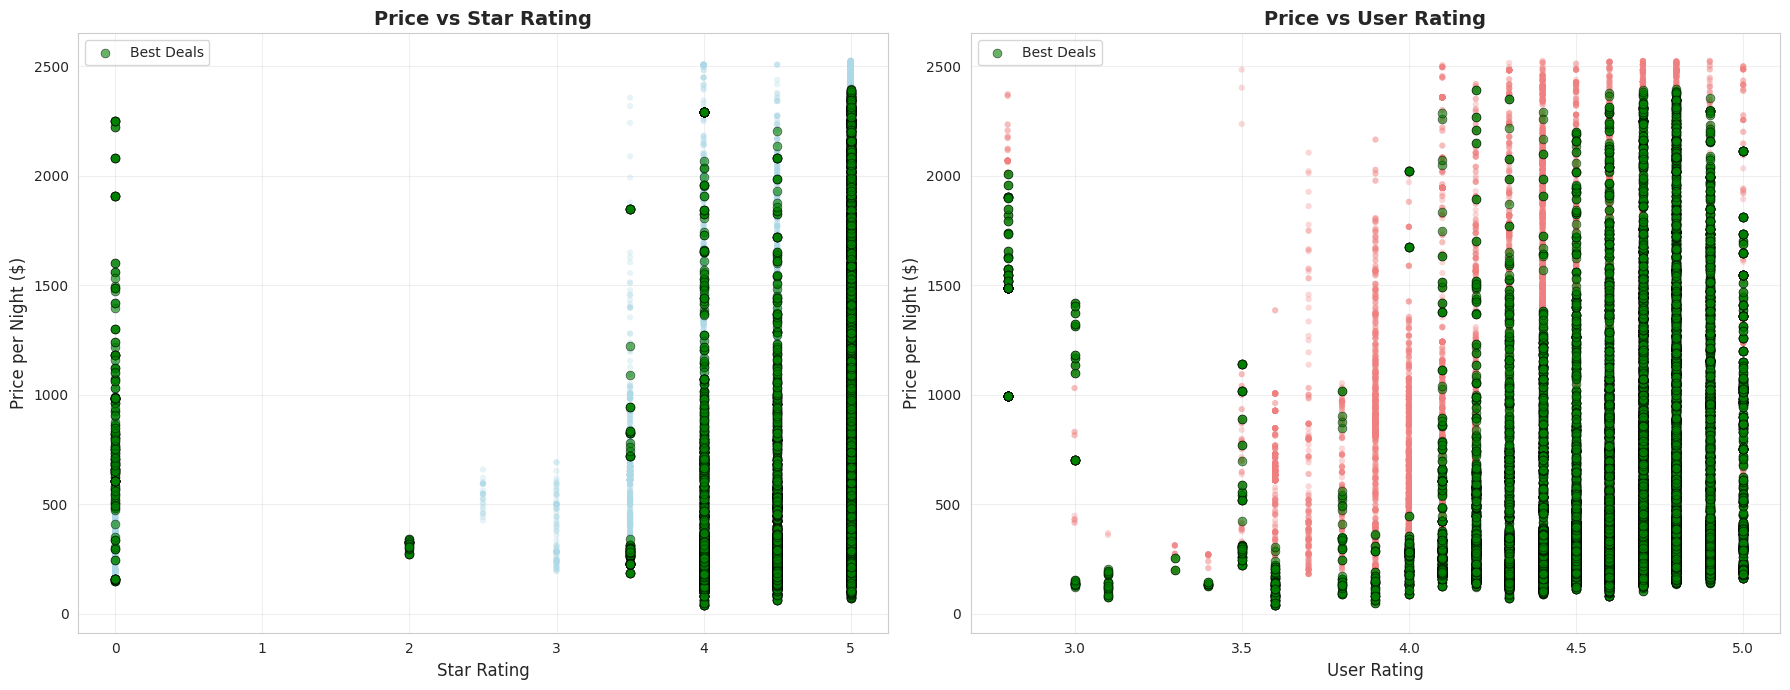

In [18]:
# Scatter plot: Price vs Star Rating
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Price vs Star Rating
scatter_data = rates_df[rates_df['star_rating'].notna() & (rates_df['price_per_night'] < rates_df['price_per_night'].quantile(0.95))]
axes[0].scatter(scatter_data['star_rating'], scatter_data['price_per_night'], 
                alpha=0.3, s=20, c='lightblue', edgecolors='none')

# Highlight best deals
best_scatter = best_deals[best_deals['star_rating'].notna() & (best_deals['price_per_night'] < best_deals['price_per_night'].quantile(0.95))]
axes[0].scatter(best_scatter['star_rating'], best_scatter['price_per_night'], 
                alpha=0.6, s=40, c='green', edgecolors='black', linewidths=0.5, label='Best Deals')

axes[0].set_xlabel('Star Rating', fontsize=12)
axes[0].set_ylabel('Price per Night ($)', fontsize=12)
axes[0].set_title('Price vs Star Rating', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Price vs User Rating
scatter_data2 = rates_df[rates_df['user_rating'].notna() & (rates_df['price_per_night'] < rates_df['price_per_night'].quantile(0.95))]
axes[1].scatter(scatter_data2['user_rating'], scatter_data2['price_per_night'], 
                alpha=0.3, s=20, c='lightcoral', edgecolors='none')

# Highlight best deals
best_scatter2 = best_deals[best_deals['user_rating'].notna() & (best_deals['price_per_night'] < best_deals['price_per_night'].quantile(0.95))]
axes[1].scatter(best_scatter2['user_rating'], best_scatter2['price_per_night'], 
                alpha=0.6, s=40, c='green', edgecolors='black', linewidths=0.5, label='Best Deals')

axes[1].set_xlabel('User Rating', fontsize=12)
axes[1].set_ylabel('Price per Night ($)', fontsize=12)
axes[1].set_title('Price vs User Rating', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Special Offers & Promotions Deep Dive

In [19]:
# Load promotions data
promo_query = """
SELECT 
    hp.property_id,
    h.name as hotel_name,
    hp.promotion_code,
    hp.promotion_type,
    hp.title,
    hp.description,
    hp.min_nights,
    hp.max_nights,
    hp.stay_start,
    hp.stay_end
FROM hotel_promotions hp
JOIN hotels h ON hp.property_id = h.property_id
LIMIT 1000;
"""

promotions_df = pd.read_sql_query(promo_query, conn)
print(f"\n📢 PROMOTIONS ANALYSIS:")
print("="*80)
print(f"Total promotions in database: {len(promotions_df):,}")

if len(promotions_df) > 0:
    print(f"\nPromotion types:")
    print(promotions_df['promotion_type'].value_counts().head(10))
    
    print("\nSample promotions:")
    display(promotions_df[['hotel_name', 'title', 'description', 'stay_start', 'stay_end']].head(10))
else:
    print("No promotions found in database")


📢 PROMOTIONS ANALYSIS:
Total promotions in database: 1,000

Promotion types:
promotion_type
UPSELL           619
SPECIAL_OFFER    381
Name: count, dtype: int64

Sample promotions:


,hotel_name,title,description,stay_start,stay_end
0,The Peninsula Tokyo,None,Receive a complimentary fourth night when book...,2026-01-04,2026-12-19
1,Hotel New Otani Tokyo EXECUTIVE HOUSE ZEN,None,Receive a complimentary third night when booki...,2024-02-16,2026-03-13
2,InterContinental Osaka by IHG,None,Receive a complimentary third night when booki...,2024-10-01,2026-12-31
3,Conrad Osaka,None,Receive 25% off the nightly room rate on selec...,2025-02-01,2026-12-31
4,Fauchon Hotel Kyoto,None,Receive a complimentary fourth night when book...,2025-07-12,2026-12-26
5,Six Senses Kyoto,None,Receive a complimentary third night when booki...,2025-07-01,2026-12-31
6,Conrad Tokyo,None,Receive a complimentary third night when booki...,2024-01-01,2026-03-19
7,The Okura Tokyo,None,Receive a complimentary third night when booki...,2026-01-04,2026-03-13
8,Palace Hotel Tokyo,None,Receive a complimentary third night when booki...,2025-07-01,2026-03-20
9,"Mandarin Oriental, Tokyo",None,Receive a complimentary third night when booki...,2025-03-29,2026-03-20


## 10. Hotel Collections Analysis (FHR, THC, etc.)


🏨 HOTEL COLLECTIONS ANALYSIS:
                  count  price_per_night  value_score  star_rating  \
hotel_collection                                                     
FHR               68234      1207.090694    29.367008     4.889249   
THC               31766       495.886573    31.592785     4.430161   

                  user_rating  
hotel_collection               
FHR                  4.570596  
THC                  4.466451  


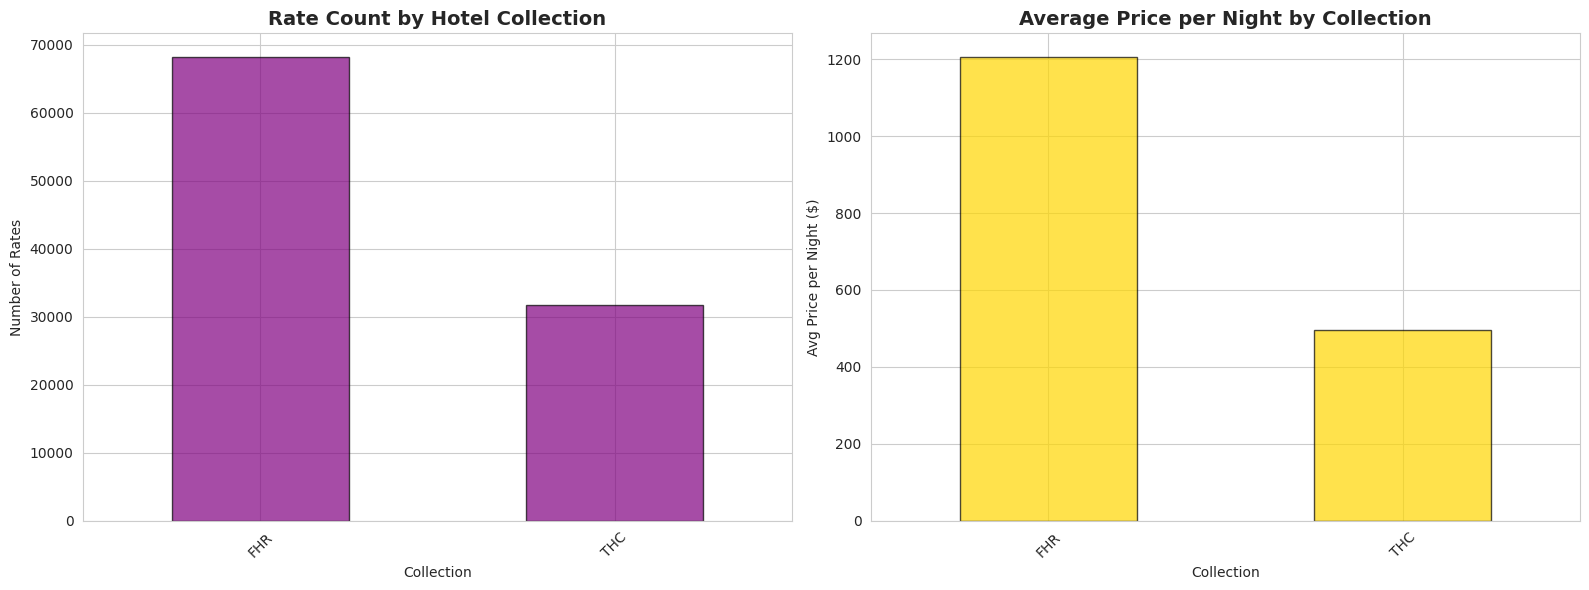

In [20]:
# Analyze hotel collections
collection_stats = rates_df[rates_df['hotel_collection'].notna()].groupby('hotel_collection').agg({
    'snapshot_id': 'count',
    'price_per_night': 'mean',
    'value_score': 'mean',
    'star_rating': 'mean',
    'user_rating': 'mean'
}).rename(columns={'snapshot_id': 'count'}).sort_values('count', ascending=False)

if len(collection_stats) > 0:
    print("\n🏨 HOTEL COLLECTIONS ANALYSIS:")
    print("="*80)
    print(collection_stats)
    
    # Plot collection distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    collection_stats['count'].plot(kind='bar', ax=axes[0], color='purple', alpha=0.7, edgecolor='black')
    axes[0].set_title('Rate Count by Hotel Collection', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Rates')
    axes[0].set_xlabel('Collection')
    axes[0].tick_params(axis='x', rotation=45)
    
    collection_stats['price_per_night'].plot(kind='bar', ax=axes[1], color='gold', alpha=0.7, edgecolor='black')
    axes[1].set_title('Average Price per Night by Collection', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Avg Price per Night ($)')
    axes[1].set_xlabel('Collection')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo hotel collection data available")

## 11. Recommendations for Surfacing Best Deals

In [21]:
print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                    📊 RECOMMENDATIONS FOR SURFACING BEST DEALS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. VALUE SCORE METHODOLOGY
   ─────────────────────────
   ✓ Use composite value score combining:
     • Amenity Score (breakfast, F&B credit, parking, etc.)
     • Star Rating per Dollar
     • User Rating Quality
     • Special Offer Availability
     • Premium Collection Status
   
   ✓ Filter criteria for "Best Deals":
     • Value Score >= 75th percentile
     • Minimum user rating (e.g., 4.0+)
     • At least 2 included amenities

2. USER INTERFACE RECOMMENDATIONS
   ────────────────────────────────
   ✓ Create dedicated "Best Value" filter/section
   ✓ Display value indicators:
     • "Great Deal" badge for top 25% value scores
     • "Best Price" badge for lowest price in category
     • "Most Amenities" badge for high amenity scores
   
   ✓ Show comparative metrics:
     • "X% below average for this destination"
     • "Includes $Y value in amenities"
     • Star rating to price ratio visualization

3. SORTING & FILTERING OPTIONS
   ────────────────────────────
   ✓ Default sort: Value Score (highest first)
   ✓ Alternative sorts:
     • Price per Night (low to high)
     • Star Rating (high to low)
     • User Rating (high to low)
     • Amenity Count (most to least)
   
   ✓ Filters:
     • Has Special Offer (yes/no)
     • Included Amenities (breakfast, parking, etc.)
     • Premium Collections (FHR, THC, etc.)
     • Price range
     • Star rating range

4. TEMPORAL OPTIMIZATION
   ─────────────────────
   ✓ Show "Best Dates" based on:
     • Highest concentration of deals
     • Lowest average prices
     • Maximum value scores
   
   ✓ Date range recommendations:
     • "Save $X by shifting dates by Y days"
     • "More deals available [date range]"

5. PERSONALIZATION OPPORTUNITIES
   ──────────────────────────────
   ✓ Learn user preferences:
     • Which amenities matter most?
     • Price sensitivity level
     • Star rating preferences
   
   ✓ Adjust value score weights based on preferences
   ✓ "Recommended for you" based on past bookings

6. ALERT & NOTIFICATION SYSTEM
   ────────────────────────────
   ✓ Price drop alerts
   ✓ New special offers
   ✓ "Exceptional value" notifications (top 10% scores)
   ✓ Limited availability warnings

7. COMPARISON TOOLS
   ─────────────────
   ✓ Side-by-side comparison of up to 3 hotels
   ✓ Show value metrics for each
   ✓ Highlight which offers best value in each category

8. DATA QUALITY CHECKS
   ───────────────────
   ✓ Exclude outliers (extreme prices)
   ✓ Require minimum data quality:
     • Valid pricing
     • Recent user ratings
     • Complete amenity information

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print(f"\n✅ Analysis complete! Generated insights from {len(rates_df):,} rate snapshots.")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                    📊 RECOMMENDATIONS FOR SURFACING BEST DEALS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. VALUE SCORE METHODOLOGY
   ─────────────────────────
   ✓ Use composite value score combining:
     • Amenity Score (breakfast, F&B credit, parking, etc.)
     • Star Rating per Dollar
     • User Rating Quality
     • Special Offer Availability
     • Premium Collection Status

   ✓ Filter criteria for "Best Deals":
     • Value Score >= 75th percentile
     • Minimum user rating (e.g., 4.0+)
     • At least 2 included amenities

2. USER INTERFACE RECOMMENDATIONS
   ────────────────────────────────
   ✓ Create dedicated "Best Value" filter/section
   ✓ Display value indicators:
     • "Great Deal" badge for top 25% value scores
     • "Best Price" badge for lowest price in category
     • "Most Amenities" badge for high amenity scores

   ✓ Show comparative metri

## 12. Export Best Deals for Further Analysis

In [22]:
# Export best deals to CSV
output_path = Path('../data/exports/best_deals.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)

export_cols = [
    'hotel_name', 'destination_name', 'check_in', 'check_out', 'nights',
    'price_per_night', 'pricing_total', 'star_rating', 'user_rating',
    'amenity_score', 'value_score', 'is_breakfast_included', 
    'is_food_beverage_credit', 'is_free_cancellation', 'is_parking_included',
    'has_special_offer', 'hotel_collection', 'property_id'
]

best_deals[export_cols].to_csv(output_path, index=False)
print(f"\n✅ Exported {len(best_deals):,} best deals to: {output_path}")

# Also export summary statistics
summary_path = Path('../data/exports/deal_summary_by_destination.csv')
deals_by_dest.to_csv(summary_path)
print(f"✅ Exported destination summary to: {summary_path}")


✅ Exported 25,001 best deals to: ../data/exports/best_deals.csv
✅ Exported destination summary to: ../data/exports/deal_summary_by_destination.csv


In [23]:
# Close database connection
conn.close()
print("\n✓ Database connection closed")


✓ Database connection closed
